   
WarmUp
=======

Trend-Seasonal
=======

Differencing
===========

Exponential-smoothing
===================


**Times series course**  
IMT Mines ALES  
2IA - 2022



In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [15, 5]


Month
1995-01-01    266.0
1995-02-01    145.9
1995-03-01    183.1
1995-04-01    119.3
1995-05-01    180.3
Name: Sales, dtype: float64

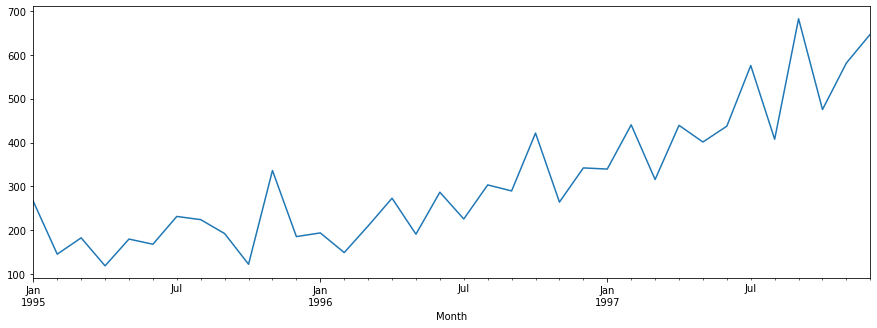

In [2]:
from datetime import datetime

def parser(x):
    return datetime.strptime( '199' + x, '%Y-%m') + pd.offsets.DateOffset(years=4)
 
df = pd.read_csv('../data/shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
df.plot()
df.head()


In [3]:
data = df.values.tolist()
print(data[:10])



[266.0, 145.9, 183.1, 119.3, 180.3, 168.5, 231.8, 224.5, 192.8, 122.9]


## Simple exponential smoothing

Implement the simple exponential smoothing from its update equation. Please write a recursive function `simple_es(series, alpha)`.  

Forecast the last value of the time series (as it were unknown).    
Plot it on a graph.

SES on last value:  491.5093239011532
Original last value:  646.9


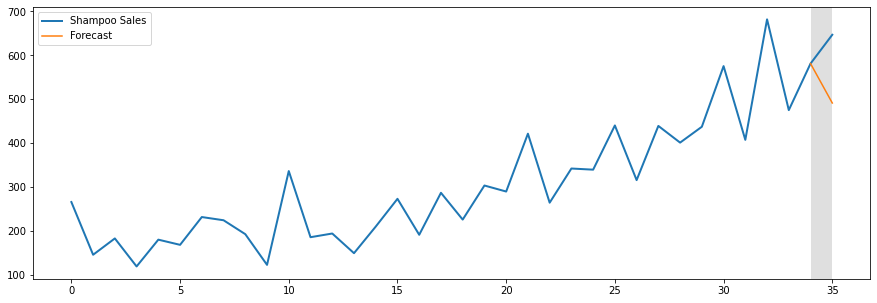

In [4]:
# Correction
#The modèle ne prédit qu'un futur constant (ne dépend pas de l'horizon h). C'et une moyenne pondérée des observation passées et on prend a [0,1]. 
#Plus a tend vers 1 et plus le poids diminue

def simple_es(series, alpha):
    
    if len(series) == 1:
        return series[0]

    return alpha * series[-1] + (1 - alpha) * simple_es(series[:-1], alpha)

forecast_last_value = simple_es(data[:-1], alpha=0.2)

print("SES on last value: ", forecast_last_value)
print("Original last value: ", data[-1])

final_months = (34, 35)
forecast = simple_es(data[:-1], alpha=0.2)
plt.plot(data, linewidth=2, label='Shampoo Sales')
plt.plot(final_months, [data[-2], forecast], label='Forecast')
plt.axvspan(*final_months, facecolor='grey', alpha=0.25)
plt.legend()
plt.show()

**Correction**

The grey bar represents the forecasted month. No surprise, the forecast is terrible — quite literally in the opposite direction. This is to be expected as simple exponential smoothing is just that: simple. It does not consider any kind of trend or seasonality and was therefore doomed from the start with this particular data set.

Create a vector to see the estimation at each time step. Plot the graph. Try different values of alpha.

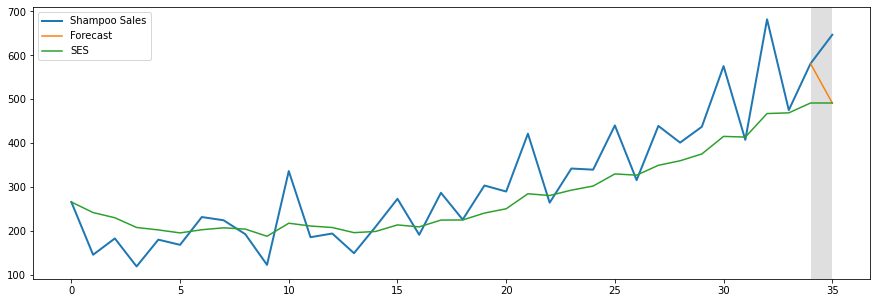

In [5]:
# Correction

forecast_list = []
for i in range(1, len(data)):
    forecast_list.append(simple_es(data[:i], alpha=0.2))

forecast_list.append(forecast_list[-1])

plt.plot(data, linewidth=2, label='Shampoo Sales')
plt.plot(final_months, [data[-2], forecast], label='Forecast')
plt.plot(forecast_list, label="SES")
plt.axvspan(*final_months, facecolor='grey', alpha=0.25)
plt.legend()
plt.show()

The smoothing action can clearly be seen.

### None seasonal Holt-Winters exponential smoothing

Build a recursive function `double_es(series, alpha, beta)` that:
- return a trend using the trend update equation,
- use the `simple_es` function to calculate the level l(n) and l(n-1),
- use data[1] - data[0] as initial trend

Compute the forecasting on the last value.

In [6]:
# Correction

def double_es(data, alpha, beta):
    # return trend 
    if len(data) == 2:
        return data[1] - data[0]

    level_n = simple_es(data, alpha)
    level_n_prev = simple_es(data[:-1], alpha)

    trend_n_prev = double_es(data[:-1], alpha, beta)

    return (beta * (level_n - level_n_prev)) + ((1 - beta) * trend_n_prev)

In [7]:
initial_trend = data[1] - data[0]
level_estimate = simple_es(data[:-1], 0.2)

In [8]:
#forecast = level_estimate + double_es(data[:-1], 0.2, 0.3, initial_trend)
forecast = level_estimate + double_es(data[:-1], 0.2, 0.3)
forecast

511.4485703448266

In [9]:
forecast_list = []
for i in range(2, len(data)+1):
    forecast_list.append(simple_es(data[:i], alpha=0.2) + double_es(data[:i], 0.2, 0.3))

forecast_list.append(forecast)   
forecast_list[-1]

511.4485703448266

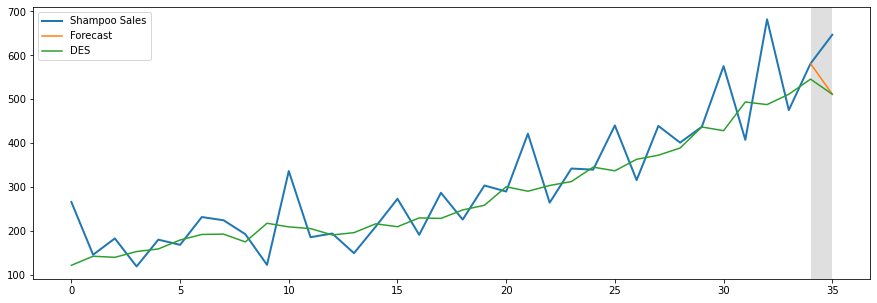

In [10]:
plt.plot(data, linewidth=2, label='Shampoo Sales')
plt.plot(final_months, [data[-2], forecast], label='Forecast')
plt.plot(forecast_list, label="DES")
plt.axvspan(*final_months, facecolor='grey', alpha=0.25)
plt.legend()
plt.show()

## Exponential smoothing with built-in functions

In [11]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt



### Simple exponential smoothing

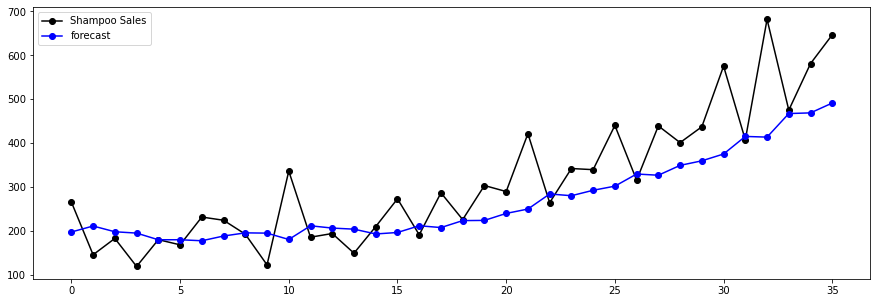

In [12]:
# Explicitly provide alpha to the model 
fit1 = SimpleExpSmoothing(data, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False)

plt.plot(data, marker="o", color="black", label='Shampoo Sales')
plt.plot(fit1.fittedvalues, marker="o", color="blue", label='forecast')
plt.legend()
plt.show()

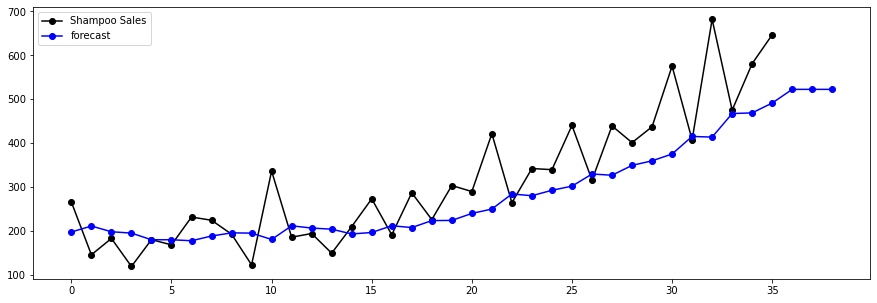

In [13]:
# Make forecasting 

forecast = fit1.forecast(3)
full_curve = np.concatenate((fit1.fittedvalues, forecast))

plt.plot(data, marker="o", color="black", label='Shampoo Sales')
plt.plot(full_curve, marker="o", color="blue", label='forecast')
plt.legend()
plt.show()

Use `statsmodel` to provide an optimized value for alpha.

In [14]:
# Correction

# statsmodels find automatically an optimized value for alpha
fit2 = SimpleExpSmoothing(data, initialization_method="estimated").fit()
fit2.params_formatted

,name,param,optimized
smoothing_level,alpha,0.399385,True
initial_level,l.0,202.779274,True


### None seasonal Holt-Winters exponential smoothing

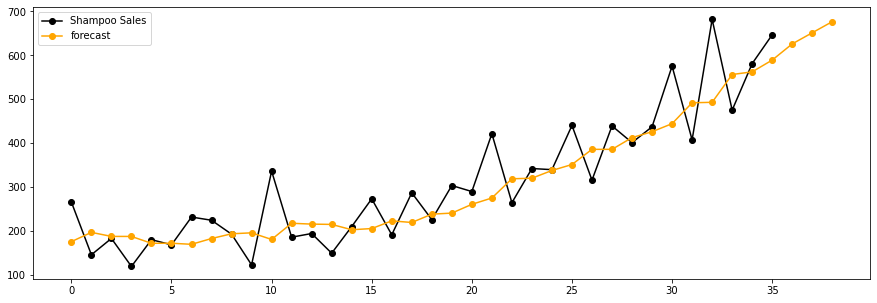

In [15]:
fit1 = Holt(data, initialization_method="estimated").fit(
    smoothing_level=0.2, smoothing_trend=0.2)

forecast = fit1.forecast(3)
full_curve = np.concatenate((fit1.fittedvalues, forecast))


plt.plot(data, marker="o", color="black", label='Shampoo Sales')
plt.plot(full_curve, marker="o", color="orange", label='forecast')
plt.legend()
plt.show()

### Holt’s Winters Seasonal

In [16]:
# The folowing data corresponds to the international visitor night in Australia (millions)

data = [
    41.7275,
    24.0418,
    32.3281,
    37.3287,
    46.2132,
    29.3463,
    36.4829,
    42.9777,
    48.9015,
    31.1802,
    37.7179,
    40.4202,
    51.2069,
    31.8872,
    40.9783,
    43.7725,
    55.5586,
    33.8509,
    42.0764,
    45.6423,
    59.7668,
    35.1919,
    44.3197,
    47.9137,
]
index = pd.date_range(start="2005", end="2010-Q4", freq="QS-OCT")
aust = pd.Series(data, index) # note that we can use the pandas's Series type instead of the pandas's dataframe

<AxesSubplot:>

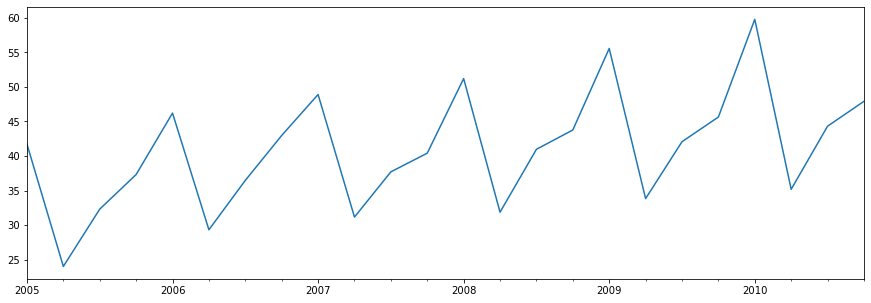

In [17]:
aust.plot()

How could you find the periodicity for this data? 

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

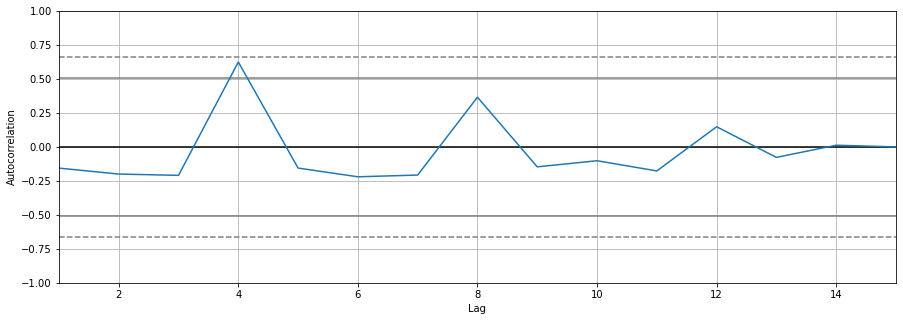

In [18]:
# Correction

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(aust[0:15])

# -> The periodicity is 4

The following cell fit a Holt’s Winters Seasonal model. What does mean these parameters?

In [19]:
fit3 = ExponentialSmoothing(
    aust,
    seasonal_periods = 4,
    trend = "add",
    seasonal = "add",
    use_boxcox = False,
    initialization_method = "estimated",
).fit()

In [20]:
# Correction

# seasonal_periods: the number of periods in a complete seasonal cycle, e.g., 4 for quarterly data or 7 for daily data with a weekly cycle
# trend : type of trend component (here "add" means "additive")
# seasonal : type of seasonal component (here "add" means "additive")
# use_boxcox: if true, a Box-Cox transform is applied to the data first
# initialization_method: method for initialize the recursions


Forecast the time series for ten time steps. Plot the results.

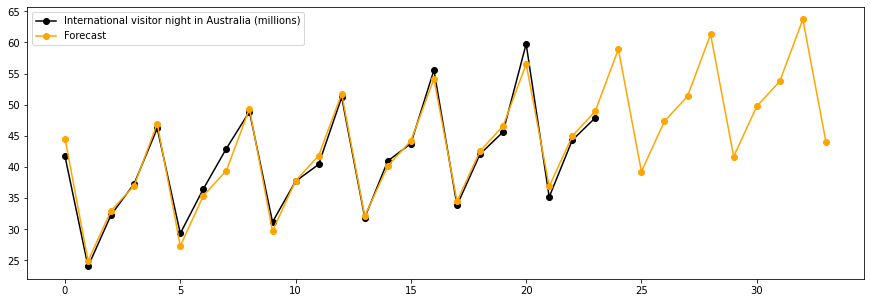

In [21]:
# Correction

forecast = fit3.forecast(10)
full_curve = np.concatenate((fit3.fittedvalues, forecast))


plt.plot(aust.values, marker="o", color="black", label='International visitor night in Australia (millions)')
plt.plot(full_curve, marker="o", color="orange", label='Forecast')
plt.legend()
plt.show()

- Simple (single) exponential smoothing uses a weighted moving average with exponentially decreasing weights.

- Holt’s trend-corrected double exponential smoothing is usually more reliable for handling data that shows trends, compared to the single procedure.

- Triple exponential smoothing (also called the Multiplicative Holt-Winters) is usually more reliable for parabolic trends or data that shows trends and seasonality..

### Double exponential smoothing

Build a recursive function `double_es(series, alpha, beta)` that:
- return a trend using the trend update equation,
- use the `simple_es` function to calculate the level l(n) and l(n-1),
- use data[1] - data[0] as initial trend

Compute the forecasting on the last value.

In [23]:
def double_es(series, alpha, beta):
    
        if len(data) == 2:
            return data[1] - data[0]
        
        level_n = simple_es(data,alpha)
        level_n_prev = simple_es_(data)

In [24]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [25]:
fit1 = SimpleExpSmoothing(data, initialization_method = 'heuristic').fit(smoothing_level = 0.05, optimized = False)